## Setup

In [15]:
import sys, os
sys.path.append(os.path.abspath('../src'))
sys.path.append(os.path.abspath('..'))

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

torch.set_grad_enabled(False)
device = torch.device('cuda:0')

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm

# Custom lib
from model import LatentNeuralODEBuilder
from utils import gpu, asnp

In [16]:
class SineSet(Dataset):
    def __init__(self, data, time):
        self.data = data
        self.time = time
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.time

In [50]:
model_path = "../models/"

# Need to be replaced.
# run_1 = "sine_base_lode_1_1_2021-04-10 00:45:41.187330"
# run_2 = "sine_base_lode_1_1_2021-04-10 00:50:45.503356"
# run_3 = "sine_base_lode_1_1_2021-04-10 00:59:32.700574"

# run_1 = "sine_iwae_lode_1_5_2021-04-10 00:07:26.055046"
# run_2 = "sine_iwae_lode_1_5_2021-04-10 00:42:55.636574"
# run_3 = "sine_iwae_lode_1_5_2021-04-10 00:48:03.676548"

# run_1 = "sine_iwae_lode_1_10_2021-04-10 00:14:19.086817"
# run_2 = "sine_iwae_lode_1_10_2021-04-10 00:25:30.215114"
# run_3 = "sine_iwae_lode_1_10_2021-04-10 00:33:20.224466"

run_1 = "sine_iwae_lode_1_25_2021-04-10 00:40:34.210478"
run_2 = "sine_iwae_lode_1_25_2021-04-10 01:16:00.895996"
run_3 = "sine_iwae_lode_1_25_2021-04-10 02:31:22.929243"

model_data_1 = torch.load(model_path + run_1)
model_data_2 = torch.load(model_path + run_2)
model_data_3 = torch.load(model_path + run_3)

In [28]:
generator = torch.load('../' + model_data_1['data_path'])['generator']

test_time, test_data = generator.get_test_set()
test_data = test_data.reshape(len(test_data), -1, 1)

test_data_tt = gpu(test_data)
test_time_tt = gpu(test_time)

test_dataset = SineSet(test_data_tt, test_time_tt)
test_loader = DataLoader(test_dataset, batch_size = len(test_dataset))

In [29]:
# TODO: Move into model args.
elbo_type = 'iwae'

base_model = LatentNeuralODEBuilder(**model_data_1['model_args'])

model_1 = base_model.build_latent_node(elbo_type).to(device)
model_2 = base_model.build_latent_node(elbo_type).to(device)
model_3 = base_model.build_latent_node(elbo_type).to(device)

In [30]:
model_1.load_state_dict(model_data_1['model_state_dict'])
model_2.load_state_dict(model_data_2['model_state_dict'])
model_3.load_state_dict(model_data_3['model_state_dict'])

<All keys matched successfully>

In [31]:
train_args = model_data_1['train_args']

## Loss Calculation

In [35]:
M = train_args['M']
K = train_args['K']

out_1 = model_1.forward(test_data_tt, test_time_tt, M, K)
elbo_1 = model_1.get_elbo(test_data_tt, *out_1, M, K, model_data_1['train_args']['l_std'])

out_2 = model_2.forward(test_data_tt, test_time_tt, M, K)
elbo_2 = model_2.get_elbo(test_data_tt, *out_2, M, K, model_data_2['train_args']['l_std'])

out_3 = model_3.forward(test_data_tt, test_time_tt, M, K)
elbo_3 = model_3.get_elbo(test_data_tt, *out_3, M, K, model_data_3['train_args']['l_std'])

mse_1 = nn.MSELoss()(test_data_tt, torch.mean(out_1[0], 1))
mse_2 = nn.MSELoss()(test_data_tt, torch.mean(out_2[0], 1))
mse_3 = nn.MSELoss()(test_data_tt, torch.mean(out_3[0], 1))

In [36]:
elbos = torch.Tensor([elbo_1, elbo_2, elbo_3])
mses = torch.Tensor([mse_1, mse_2, mse_3])

print("ELBO: {:.2f}±{:.2f}".format(torch.mean(elbos), torch.std(elbos)))
print("MSE: {:.4f}±{:.4f}".format(torch.mean(mses), torch.std(mses)))

ELBO: 4884.01±8.37
MSE: 0.5121±0.0008


## Training Dynamics

In [143]:
def load_data(model_path, p1, p2, p3):
    d1 = torch.load(model_path + p1)
    d2 = torch.load(model_path + p2)
    d3 = torch.load(model_path + p3)
    
    return [d1, d2, d3]

In [147]:
# Need to be replaced.
base_1 = "sine_base_lode_1_1_2021-04-10 00:45:41.187330"
base_2 = "sine_base_lode_1_1_2021-04-10 00:50:45.503356"
base_3 = "sine_base_lode_1_1_2021-04-10 00:59:32.700574"

iwae_1_5_1 = "sine_iwae_lode_1_5_2021-04-10 00:07:26.055046"
iwae_1_5_2 = "sine_iwae_lode_1_5_2021-04-10 00:42:55.636574"
iwae_1_5_3 = "sine_iwae_lode_1_5_2021-04-10 00:48:03.676548"

iwae_1_10_1 = "sine_iwae_lode_1_10_2021-04-10 00:14:19.086817"
iwae_1_10_2 = "sine_iwae_lode_1_10_2021-04-10 00:25:30.215114"
iwae_1_10_3 = "sine_iwae_lode_1_10_2021-04-10 00:33:20.224466"

iwae_1_25_1 = "sine_iwae_lode_1_25_2021-04-10 00:40:34.210478"
iwae_1_25_2 = "sine_iwae_lode_1_25_2021-04-10 01:16:00.895996"
iwae_1_25_3 = "sine_iwae_lode_1_25_2021-04-10 02:31:22.929243"

In [149]:
base = load_data(model_path, base_1, base_2, base_3)
iwae_1_5 = load_data(model_path, iwae_1_5_1, iwae_1_5_2, iwae_1_5_3)
iwae_1_10 = load_data(model_path, iwae_1_10_1, iwae_1_10_2, iwae_1_10_3)
iwae_1_25 = load_data(model_path, iwae_1_25_1, iwae_1_25_2, iwae_1_25_3)

In [150]:
def get_train_times(d1, d2, d3):
    train_1 = d1['train_obj']
    train_2 = d2['train_obj']
    train_3 = d3['train_obj']
    
    rt1 = np.mean(train_1.runtimes)
    rt2 = np.mean(train_2.runtimes)
    rt3 = np.mean(train_3.runtimes)
    
    avg_rt = np.mean([rt1, rt2, rt3])
    print("Avg Epoch Time: {}".format(avg_rt))
    return avg_rt

In [151]:
iwae_1_5_rt = get_train_times(*iwae_1_5)
iwae_1_10_rt = get_train_times(*iwae_1_10)
iwae_1_25_rt = get_train_times(*iwae_1_25)

Avg Epoch Time: 61.072596869866054
Avg Epoch Time: 59.428685742219294
Avg Epoch Time: 67.61594797790052


In [152]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [171]:
def plot_val_loss(d1, d2, d3, title, trunc_l=25, trunc_r=250):
    train_1 = d1['train_obj']
    train_2 = d2['train_obj']
    train_3 = d3['train_obj']

    val1 = np.array(train_1.val_loss_hist)
    val2 = np.array(train_2.val_loss_hist)
    val3 = np.array(train_3.val_loss_hist)
    
    val1 = moving_average(val1, 10)
    val2 = moving_average(val2, 10)
    val3 = moving_average(val3, 10)

    mean_val = np.mean([val1, val2, val3], 0)
    std_val = np.std([val1, val2, val3], 0)

    time = range(len(val1))

    mean_val = mean_val[trunc_l:trunc_r]
    std_val = std_val[trunc_l:trunc_r]
    time = time[trunc_l:trunc_r]

    plt.plot(time, mean_val, label=title)
    plt.fill_between(time, mean_val + std_val, mean_val - std_val, alpha=0.3)

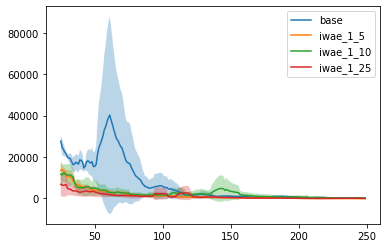

In [172]:
plot_val_loss(*base, 'base')
plot_val_loss(*iwae_1_5, 'iwae_1_5')
plot_val_loss(*iwae_1_10, 'iwae_1_10')
plot_val_loss(*iwae_1_25, 'iwae_1_25')
plt.legend()

## Visualization

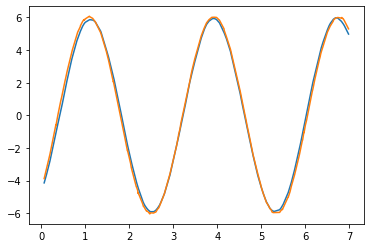

In [173]:
ind = 0
plt.plot(asnp(test_time_tt), asnp(torch.mean(out_1[0][ind], 0)))
plt.plot(asnp(test_time_tt), asnp(test_data_tt[ind]))